In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
import requests
import io
import apache_log_parser
from pprint import pprint
import os
import EntropyHub as EH

In [11]:
from typing import List

log_line_data = None
line_parser = apache_log_parser.make_parser("%h %l %u %t \"%r\" %>s %b")
with open(f"{os.getcwd()}/NASA_access_log_Jul95.log", mode='r') as f1:
    with open(f"{os.getcwd()}/NASA_access_log_Aug95.log", mode='r') as f2:
        log_line_data = [line_parser(line) for line in f1.readlines() + f2.readlines()]


KeyboardInterrupt: 

In [5]:
df_log_line_data = pd.DataFrame([{"date": df_line["time_received_datetimeobj"], "count": 1} for df_line in log_line_data])
df_log_line_data

,date,count
0,1995-07-01 00:00:01,1
1,1995-07-01 00:00:06,1
2,1995-07-01 00:00:09,1
3,1995-07-01 00:00:11,1
4,1995-07-01 00:00:11,1
...,...,...
3461607,1995-08-31 23:59:49,1
3461608,1995-08-31 23:59:49,1
3461609,1995-08-31 23:59:52,1
3461610,1995-08-31 23:59:52,1


In [6]:
raw_df_S = df_log_line_data.groupby(pd.Grouper(key="date", freq="6S")).sum().reset_index()
raw_df_S.size

1785598

In [14]:
df_S = raw_df_S[:25]
df_S.size

50

In [43]:
df_S_date = (pd.to_datetime(df_S["date"]).astype(int) / 10**9).array.reshape(-1, 1)
df_S_count = df_S["count"].array.reshape(-1, 1)

In [15]:
countSamp = EH.SampEn(df_S["count"].to_numpy(), m = 4)

In [16]:
countSamp

(array([2.52572864, 3.04452244,        inf,        nan,        nan]),
 array([24.,  1.,  0.,  0.,  0.]),
 array([300.,  21.,   1.,   0.,   0.]))

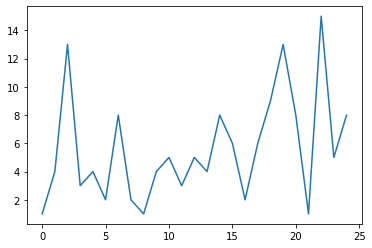

In [17]:
plt.plot(df_S["count"].to_numpy())

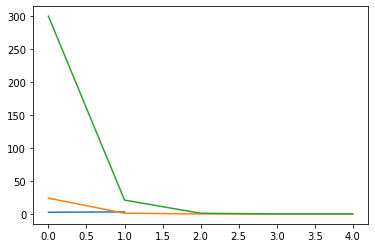

In [21]:
plt.plot(countSamp[0])
plt.plot(countSamp[1])
plt.plot(countSamp[2])


In [22]:
ApSamp = EH.ApEn(df_S["count"].to_numpy())

In [23]:
ApSamp

(array([2.34216092, 0.90688568, 0.01520265]),
 array([ 0.12875503, -2.21340588, -3.12029157, -3.13549422]))

In [8]:
sample = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.4, 0.3, 0.2, 0.1, 0, -0.1, -0.2, -0.3, -0.4, -0.5]
ApSamp = EH.ApEn(sample, m=2, r=0.15)

In [27]:
ApSamp

(array([1.48672692, 0.32522467, 0.2215329 ]),
 array([ 0.14497726, -1.34174966, -1.66697433, -1.88850723]))

In [14]:
def ApEn(U, m, r):

    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)

    return abs(_phi(m + 1) - _phi(m))

In [34]:
ApEn(sample * 10, 2, 0.15)

0.24831596141292178

In [5]:
rand_sample = [np.random.uniform(low=-0.5, high=0.5) for _x in range(140)]

In [1]:
ApEn(rand_sample, 2, 0.15)

NameError: name 'ApEn' is not defined

In [13]:

import neurokit2 as nk
nk.entropy_approximate(np.array(rand_sample), dimension=2, tolerance=0.15)

(1.1335413484678138,
 {'Dimension': 2, 'Delay': 1, 'Corrected': False, 'Tolerance': 0.15})

In [15]:
nk.entropy_approximate(np.array(sample * 10), dimension=2, tolerance=0.15)

(0.24831596141292933,
 {'Dimension': 2, 'Delay': 1, 'Corrected': False, 'Tolerance': 0.15})